# Exploratory data analysis on breath data

Features explored:
* Root mean square energy (rms)
* Zero crossing rate (zcr)
* Spectral centroid (sc)
* Spectral bandwidth (sb)
* Spectral rolloff (sr)
* Mel frequency cepstral coefficients (mfcc)
* 1st (dmfcc) and 2nd (d2mfcc) derivatives of MFCCs

Distributions of above features grouped by class are saved as pickle files.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from IPython.display import Audio
from tqdm import tqdm
import pickle
import os

import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('../data_spec')
sys.path.append('../data_spec/log_spec')

from feature_extraction_utils import *
from generate_log_specs import generate_log_spectrogram
from spec_utils import generate_spectrum

In [2]:
# Paths to asthma, covid and normal breath training directories.
dirpath_asthma = os.path.join('..', 'data_raw', 'data_breath', 'train', 'asthma')
dirpath_covid = os.path.join('..', 'data_raw', 'data_breath', 'train', 'covid')
dirpath_normal = os.path.join('..', 'data_raw', 'data_breath', 'train', 'normal')

# Selecting one asthma, covid and normal audio file each randomly.
np.random.seed(42)
rand_file_asthma = os.listdir(dirpath_asthma)[np.random.randint(low=0, high=len(os.listdir(dirpath_asthma)))]
rand_file_covid = os.listdir(dirpath_covid)[np.random.randint(low=0, high=len(os.listdir(dirpath_covid)))]
rand_file_normal = os.listdir(dirpath_normal)[np.random.randint(low=0, high=len(os.listdir(dirpath_normal)))]
filepath_asthma = os.path.join(dirpath_asthma, rand_file_asthma)
filepath_covid = os.path.join(dirpath_covid, rand_file_covid)
filepath_normal = os.path.join(dirpath_normal, rand_file_normal)

# If you get a FileNotFoundError, ensure you've run make in ../data_raw.
waveform_asthma, _ = librosa.load(filepath_asthma, sr=sampling_rate)
waveform_covid, _ = librosa.load(filepath_covid, sr=sampling_rate)
waveform_normal, _ = librosa.load(filepath_normal, sr=sampling_rate)

print(f'Selected asthma breath file from train: {rand_file_asthma}')
print(f'Selected covid breath file from train: {rand_file_covid}')
print(f'Selected normal breath file from train: {rand_file_normal}')

Selected asthma breath file from train: BREATH_ASTHMA_withcough_android_[20]_breaths_2aSAZx0fOr_1587385420766.wav_aug_noise1.wav
Selected covid breath file from train: BREATH_COVID_nocough_android_[349]_breaths_f75Ucc81Xk_1587201722933.wav
Selected normal breath file from train: BREATH_NORMAL_nocough_web_[1711]_audio_file_breathe.webm


In [3]:
%%script echo "Output hidden for data privacy reasons."
Audio(filepath_asthma)

Output hidden for data privacy reasons.


In [4]:
%%script echo "Output hidden for data privacy reasons."
Audio(filepath_covid)

Output hidden for data privacy reasons.


In [5]:
%%script echo "Output hidden for data privacy reasons."
Audio(filepath_normal)

Output hidden for data privacy reasons.


## Root mean square energy

#### Results on representative samples from each class.

In [6]:
rms_asthma = rms_energy(waveform_asthma, samples_per_frame, hop_length)
rms_covid = rms_energy(waveform_covid, samples_per_frame, hop_length)
rms_normal = rms_energy(waveform_normal, samples_per_frame, hop_length)

Sanity check for shape of rms energy arrays.  
Given an audio input of $\text{audio_length}$, frame length of $\text{frame_length}$, padding of $\text{pad_length}$ on each side and a hop length of $\text{hop_length}$, the rms energy array must have length =
$$\Bigg\lfloor\frac{\text{audio_length} + 2 \times \text{pad_length} - \text{frame_length}}{\text{hop_length}}\Bigg\rfloor + 1$$
Librosa takes $\text{pad_length} = \Big\lfloor\frac{\text{frame_length}}{2}\Big\rfloor$.

In [7]:
pad_length = samples_per_frame // 2
np.testing.assert_array_equal(rms_asthma.shape[0], (waveform_asthma.shape[0] + 2 * pad_length - samples_per_frame) // hop_length + 1)
np.testing.assert_array_equal(rms_covid.shape[0], (waveform_covid.shape[0] + 2 * pad_length - samples_per_frame) // hop_length + 1)
np.testing.assert_array_equal(rms_normal.shape[0], (waveform_normal.shape[0] + 2 * pad_length - samples_per_frame) // hop_length + 1)

Plotting RMS energy over waveform.

In [8]:
%%script echo "Output hidden for data privacy reasons."

# Converting frame index to time
times_asthma = librosa.frames_to_time(range(len(rms_asthma)), sr=sampling_rate, hop_length=hop_length)
times_covid = librosa.frames_to_time(range(len(rms_covid)), sr=sampling_rate, hop_length=hop_length)
times_normal = librosa.frames_to_time(range(len(rms_normal)), sr=sampling_rate, hop_length=hop_length)

fig, ax = plt.subplots(1, 3, figsize=(19, 4))
plt.suptitle('RMS energy values for 3 representative audio samples, grouped by class, marked in red over light blue waveform')

plt.subplot(1, 3, 1)
librosa.display.waveplot(waveform_asthma, sr=sampling_rate, x_axis='time', color='b', alpha=0.2)
plt.plot(times_asthma, rms_asthma, color='r')
plt.xlabel('Time (s)')
plt.ylabel('RMS Energy')
plt.title('asthma')

plt.subplot(1, 3, 2)
librosa.display.waveplot(waveform_covid, sr=sampling_rate, x_axis='time', color='b', alpha=0.2)
plt.plot(times_covid, rms_covid, color='r')
plt.xlabel('Time (s)')
plt.ylabel('RMS Energy')
plt.title('covid')

plt.subplot(1, 3, 3)
librosa.display.waveplot(waveform_normal, sr=sampling_rate, x_axis='time', color='b', alpha=0.2)
plt.plot(times_normal, rms_normal, color='r')
plt.xlabel('Time (s)')
plt.ylabel('RMS Energy')
plt.title('normal');

Output hidden for data privacy reasons.


#### Aggregating RMS energy values across frames, to get a single value for each audio sample, then plotting the distribution of the aggregated values.

In [9]:
%%script echo "Comment line with %%script echo to run this cell."

# RMS energy distributions for asthma, covid and normal.
rms_asthma_dist = list()
rms_covid_dist = list()
rms_normal_dist = list()

# Aggregate RMS enegy distributions for asthma, covid and normal.
# Taking 95th percentile value of RMS energy across frames to aggregate.
# This blog http://replaygain.hydrogenaud.io/proposal/statistical_process.html advises 
# taking 95th percentile value for aggregation.
agg_func = 95
for file in tqdm(os.listdir(dirpath_asthma)):
    file = os.path.join(dirpath_asthma, file)
    waveform, _ = librosa.load(file, sr=sampling_rate)
    rms_asthma_dist.append(rms_energy_agg(waveform, samples_per_frame, hop_length, agg_func=agg_func))
for file in tqdm(os.listdir(dirpath_covid)):
    file = os.path.join(dirpath_covid, file)
    waveform, _ = librosa.load(file, sr=sampling_rate)
    rms_covid_dist.append(rms_energy_agg(waveform, samples_per_frame, hop_length, agg_func=agg_func))
for file in tqdm(os.listdir(dirpath_normal)):
    file = os.path.join(dirpath_normal, file)
    waveform, _ = librosa.load(file, sr=sampling_rate)
    rms_normal_dist.append(rms_energy_agg(waveform, samples_per_frame, hop_length, agg_func=agg_func))

Comment line with %%script echo to run this cell.


In [10]:
%%script echo "Comment line with %%script echo to run this cell."

# Saving RMS energy distributions.
with open('breath_dist_rms_asthma.pickle', 'wb') as f:
    pickle.dump(rms_asthma_dist, f)
with open('breath_dist_rms_covid.pickle', 'wb') as f:
    pickle.dump(rms_covid_dist, f)
with open('breath_dist_rms_normal.pickle', 'wb') as f:
    pickle.dump(rms_normal_dist, f)

Comment line with %%script echo to run this cell.


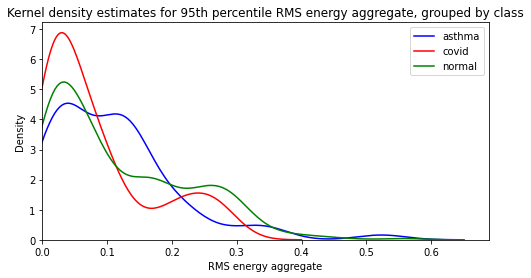

In [11]:
# Loading and plotting RMS energy distributions.

with open('breath_dist_rms_asthma.pickle', 'rb') as f:
    rms_asthma_dist = pickle.load(f)
with open('breath_dist_rms_covid.pickle', 'rb') as f:
    rms_covid_dist = pickle.load(f)
with open('breath_dist_rms_normal.pickle', 'rb') as f:
    rms_normal_dist = pickle.load(f)

plt.figure(figsize=(8, 4))
plt.title(f'Kernel density estimates for 95th percentile RMS energy aggregate, grouped by class')
sns.kdeplot(rms_asthma_dist, color='b', label='asthma')
sns.kdeplot(rms_covid_dist, color='r', label='covid')
sns.kdeplot(rms_normal_dist, color='g', label='normal')
plt.xlabel('RMS energy aggregate')
plt.xlim([0, None])
plt.legend();

## Zero crossing rate

#### Aggregating zero crossing rate values across frames, to get a single value for each audio sample, then plotting the distribution of the aggregated values.

In [12]:
%%script echo "Comment line with %%script echo to run this cell."

# Zero crossing rate (ZCR) distributions for asthma, covid and normal.
zcr_asthma_dist = list()
zcr_covid_dist = list()
zcr_normal_dist = list()

# Aggregate ZCR distributions for asthma, covid and normal.
agg_func = 'rms_energy_weighted_mean'    # Function to aggregate values over frames in audio sample, to get 1 value per audio sample.
for file in tqdm(os.listdir(dirpath_asthma)):
    file = os.path.join(dirpath_asthma, file)
    waveform, _ = librosa.load(file, sr=sampling_rate)
    zcr_asthma_dist.append(zero_crossing_rate_agg(waveform, samples_per_frame, hop_length, agg_func=agg_func))
for file in tqdm(os.listdir(dirpath_covid)):
    file = os.path.join(dirpath_covid, file)
    waveform, _ = librosa.load(file, sr=sampling_rate)
    zcr_covid_dist.append(zero_crossing_rate_agg(waveform, samples_per_frame, hop_length, agg_func=agg_func))
for file in tqdm(os.listdir(dirpath_normal)):
    file = os.path.join(dirpath_normal, file)
    waveform, _ = librosa.load(file, sr=sampling_rate)
    zcr_normal_dist.append(zero_crossing_rate_agg(waveform, samples_per_frame, hop_length, agg_func=agg_func))

Comment line with %%script echo to run this cell.


In [13]:
%%script echo "Comment line with %%script echo to run this cell."

# Saving ZCR energy distributions.
with open('breath_dist_zcr_asthma.pickle', 'wb') as f:
    pickle.dump(zcr_asthma_dist, f)
with open('breath_dist_zcr_covid.pickle', 'wb') as f:
    pickle.dump(zcr_covid_dist, f)
with open('breath_dist_zcr_normal.pickle', 'wb') as f:
    pickle.dump(zcr_normal_dist, f)

Comment line with %%script echo to run this cell.


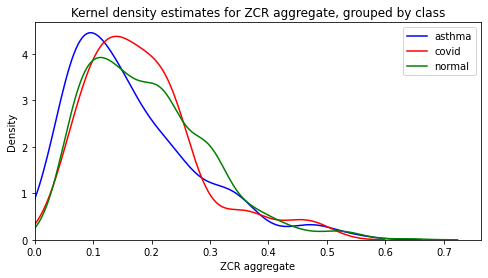

In [14]:
# Loading and plotting ZCR energy distributions.

with open('breath_dist_zcr_asthma.pickle', 'rb') as f:
    zcr_asthma_dist = pickle.load(f)
with open('breath_dist_zcr_covid.pickle', 'rb') as f:
    zcr_covid_dist = pickle.load(f)
with open('breath_dist_zcr_normal.pickle', 'rb') as f:
    zcr_normal_dist = pickle.load(f)

plt.figure(figsize=(8, 4))
plt.title(f'Kernel density estimates for ZCR aggregate, grouped by class')
sns.kdeplot(zcr_asthma_dist, color='b', label='asthma')
sns.kdeplot(zcr_covid_dist, color='r', label='covid')
sns.kdeplot(zcr_normal_dist, color='g', label='normal')
plt.xlabel('ZCR aggregate')
plt.xlim([0, None])
plt.legend();

## Spectral centroid

#### Results on representative samples from each class.

In [15]:
sc_asthma = spectral_centroid(waveform_asthma, sampling_rate, samples_per_frame, hop_length)
sc_covid = spectral_centroid(waveform_covid, sampling_rate, samples_per_frame, hop_length)
sc_normal = spectral_centroid(waveform_normal, sampling_rate, samples_per_frame, hop_length)

Sanity check for shape of spectral centroid arrays.

In [16]:
pad_length = samples_per_frame // 2
np.testing.assert_array_equal(sc_asthma.shape[0], (waveform_asthma.shape[0] + 2 * pad_length - samples_per_frame) // hop_length + 1)
np.testing.assert_array_equal(sc_covid.shape[0], (waveform_covid.shape[0] + 2 * pad_length - samples_per_frame) // hop_length + 1)
np.testing.assert_array_equal(sc_normal.shape[0], (waveform_normal.shape[0] + 2 * pad_length - samples_per_frame) // hop_length + 1)

Plotting variation of spectral centroid with time.

In [17]:
def exponential_moving_average(arr, alpha):
    if arr.ndim != 1:
        raise ValueError('Function exponential_moving_average accepts only rank 1 tensors.')
    if alpha < 0 or alpha > 1:
        raise ValueError('alpha must be in range [0, 1].')
    ema_arr = np.zeros(arr.shape)
    ema_arr[0] = arr[0]
    for i in range(1, len(arr)):
        ema_arr[i] = alpha * arr[i] + (1 - alpha) * ema_arr[i - 1]
    return ema_arr

In [18]:
%%script echo "Output hidden for data privacy reasons."

fig, ax = plt.subplots(1, 3, figsize=(19, 4))

# Smoothening factor for exponential moving average of spectral centroid values.
alpha = 0.5

plt.subplot(1, 3, 1)
plt.suptitle('Path of spectral centroid in yellow over spectrogram')

plt.title('asthma')
log_spec_asthma = generate_log_spectrogram(waveform_asthma, sampling_rate, samples_per_frame, hop_length)
# Number of frames in spectral centroid array must be equal to number of timesteps in spectrogram.
assert sc_asthma.shape[0] == log_spec_asthma.shape[1]
# Plotting spectrogram.
librosa.display.specshow(log_spec_asthma, x_axis='time', y_axis='log', sr=sampling_rate, hop_length=hop_length, alpha=0.8)
plt.colorbar(format='%+2.0f dB')
# Plotting spectral centroids over spectrogram.
frames = range(len(sc_asthma))
times = librosa.frames_to_time(frames, sr=sampling_rate, hop_length=hop_length)
plt.plot(times, exponential_moving_average(sc_asthma, alpha), color='y')
plt.xlabel('Time (s)')

plt.subplot(1, 3, 2)
plt.title('covid')
log_spec_covid = generate_log_spectrogram(waveform_covid, sampling_rate, samples_per_frame, hop_length)
# Number of frames in spectral centroid array must be equal to number of timesteps in spectrogram.
assert sc_covid.shape[0] == log_spec_covid.shape[1]
# Plotting spectrogram.
librosa.display.specshow(log_spec_covid, x_axis='time', y_axis='log', sr=sampling_rate, hop_length=hop_length, alpha=0.8)
plt.colorbar(format='%+2.0f dB')
# Plotting spectral centroids over spectrogram.
frames = range(len(sc_covid))
times = librosa.frames_to_time(frames, sr=sampling_rate, hop_length=hop_length)
plt.plot(times, exponential_moving_average(sc_covid, alpha), color='y')
plt.xlabel('Time (s)')

plt.subplot(1, 3, 3)
plt.title('normal')
log_spec_normal = generate_log_spectrogram(waveform_normal, sampling_rate, samples_per_frame, hop_length)
# Number of frames in spectral centroid array must be equal to number of timesteps in spectrogram.
assert sc_normal.shape[0] == log_spec_normal.shape[1]
# Plotting spectrogram.
librosa.display.specshow(log_spec_normal, x_axis='time', y_axis='log', sr=sampling_rate, hop_length=hop_length, alpha=0.8)
plt.colorbar(format='%+2.0f dB')
# Plotting spectral centroids over spectrogram.
frames = range(len(sc_normal))
times = librosa.frames_to_time(frames, sr=sampling_rate, hop_length=hop_length)
plt.plot(times, exponential_moving_average(sc_normal, alpha), color='y')
plt.xlabel('Time (s)');

Output hidden for data privacy reasons.


In [19]:
%%script echo "Output hidden for data privacy reasons."

# Extracting Fourier transform for each waveform.
fft_asthma, freqs_asthma = generate_spectrum(waveform_asthma, sampling_rate)
fft_covid, freqs_covid = generate_spectrum(waveform_covid, sampling_rate)
fft_normal, freqs_normal = generate_spectrum(waveform_normal, sampling_rate)

# Aggregate spectral centroids for each sample.
# Using median to avoid outlier effect on mean (several outliers where spectral centroid becomes 0).
agg_func = 'median'
agg_sc_asthma = spectral_centroid_agg(waveform_asthma, sampling_rate, samples_per_frame, hop_length, agg_func=agg_func)
agg_sc_covid = spectral_centroid_agg(waveform_covid, sampling_rate, samples_per_frame, hop_length, agg_func=agg_func)
agg_sc_normal = spectral_centroid_agg(waveform_normal, sampling_rate, samples_per_frame, hop_length, agg_func=agg_func)

fig, ax = plt.subplots(1, 3, figsize=(19, 4))
plt.suptitle('Spectral centroids marked in red over light blue spectrum')

plt.subplot(1, 3, 1)
plt.plot(freqs_asthma[:int(0.5 * len(freqs_asthma))], fft_asthma[:int(0.5 * len(freqs_asthma))], color='b', alpha=0.2)
plt.scatter(agg_sc_asthma, np.array([0]), color='r', marker='o')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('asthma');

plt.subplot(1, 3, 2)
plt.plot(freqs_covid[:int(0.5 * len(freqs_covid))], fft_covid[:int(0.5 * len(freqs_covid))], color='b', alpha=0.2)
plt.scatter(agg_sc_covid, np.array([0]), color='r', marker='o')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('covid')

plt.subplot(1, 3, 3)
plt.plot(freqs_normal[:int(0.5 * len(freqs_normal))], fft_normal[:int(0.5 * len(freqs_normal))], color='b', alpha=0.2)
plt.scatter(agg_sc_normal, np.array([0]), color='r', marker='o')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('normal');

Output hidden for data privacy reasons.


#### Aggregating spectral centroid values across frames, to get a single value for each audio sample, then plotting the distribution of the aggregated values.

In [20]:
%%script echo "Comment line with %%script echo to run this cell."

# Spectral centroid distributions for asthma, covid and normal.
sc_asthma_dist = list()
sc_covid_dist = list()
sc_normal_dist = list()

# Aggregate spectral centroids distributions for asthma, covid and normal.
agg_func = 'median'    # Function to aggregate values over frames in audio sample, to get 1 value per audio sample.
for file in tqdm(os.listdir(dirpath_asthma)):
    file = os.path.join(dirpath_asthma, file)
    waveform, _ = librosa.load(file, sr=sampling_rate)
    sc_asthma_dist.append(spectral_centroid_agg(waveform, sampling_rate, samples_per_frame, hop_length, agg_func=agg_func))
for file in tqdm(os.listdir(dirpath_covid)):
    file = os.path.join(dirpath_covid, file)
    waveform, _ = librosa.load(file, sr=sampling_rate)
    sc_covid_dist.append(spectral_centroid_agg(waveform, sampling_rate, samples_per_frame, hop_length, agg_func=agg_func))
for file in tqdm(os.listdir(dirpath_normal)):
    file = os.path.join(dirpath_normal, file)
    waveform, _ = librosa.load(file, sr=sampling_rate)
    sc_normal_dist.append(spectral_centroid_agg(waveform, sampling_rate, samples_per_frame, hop_length, agg_func=agg_func))

Comment line with %%script echo to run this cell.


In [21]:
%%script echo "Comment line with %%script echo to run this cell."

# Saving spectral centroid energy distributions.
with open('breath_dist_sc_asthma.pickle', 'wb') as f:
    pickle.dump(sc_asthma_dist, f)
with open('breath_dist_sc_covid.pickle', 'wb') as f:
    pickle.dump(sc_covid_dist, f)
with open('breath_dist_sc_normal.pickle', 'wb') as f:
    pickle.dump(sc_normal_dist, f)

Comment line with %%script echo to run this cell.


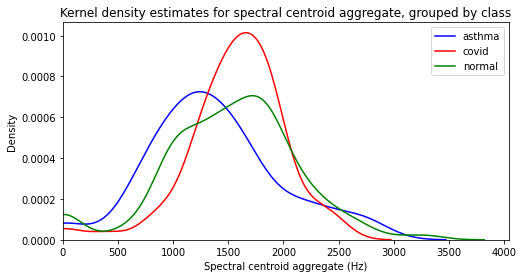

In [22]:
# Loading and plotting spectral centroid distributions.

with open('breath_dist_sc_asthma.pickle', 'rb') as f:
    sc_asthma_dist = pickle.load(f)
with open('breath_dist_sc_covid.pickle', 'rb') as f:
    sc_covid_dist = pickle.load(f)
with open('breath_dist_sc_normal.pickle', 'rb') as f:
    sc_normal_dist = pickle.load(f)

plt.figure(figsize=(8, 4))
plt.title(f'Kernel density estimates for spectral centroid aggregate, grouped by class')
sns.kdeplot(sc_asthma_dist, color='b', label='asthma')
sns.kdeplot(sc_covid_dist, color='r', label='covid')
sns.kdeplot(sc_normal_dist, color='g', label='normal')
plt.xlabel('Spectral centroid aggregate (Hz)')
plt.xlim([0, None])
plt.legend();

## Spectral bandwidth

#### Results on representative samples from each class.

In [23]:
sb_asthma = spectral_bandwidth(waveform_asthma, sampling_rate, samples_per_frame, hop_length)
sb_covid = spectral_bandwidth(waveform_covid, sampling_rate, samples_per_frame, hop_length)
sb_normal = spectral_bandwidth(waveform_normal, sampling_rate, samples_per_frame, hop_length)

Plotting bandwidth over waveform.

In [24]:
%%script echo "Output hidden for data privacy reasons."

# Converting frame index to time
times_asthma = librosa.frames_to_time(range(len(sb_asthma)), sr=sampling_rate, hop_length=hop_length)
times_covid = librosa.frames_to_time(range(len(sb_covid)), sr=sampling_rate, hop_length=hop_length)
times_normal = librosa.frames_to_time(range(len(sb_normal)), sr=sampling_rate, hop_length=hop_length)

fig, ax = plt.subplots(1, 3, sharex=True, figsize=(19, 5))
plt.suptitle('Spectral bandwidth values for 3 representative audio samples, grouped by class; waveforms in lower row')

plt.subplot(2, 3, 1)
plt.plot(times_asthma, sb_asthma, color='r')
plt.ylabel('Spectral bandwidth (Hz)')
plt.xlim([0, np.ceil(np.max(times_asthma))])
plt.title('asthma')

plt.subplot(2, 3, 4)
librosa.display.waveplot(waveform_asthma, sr=sampling_rate, x_axis='time', color='b', alpha=0.2)
plt.xlabel('Time (s)')
plt.ylabel('y')

plt.subplot(2, 3, 2)
plt.plot(times_covid, sb_covid, color='r')
plt.ylabel('Spectral bandwidth (Hz)')
plt.xlim([0, np.ceil(np.max(times_covid))])
plt.title('covid')

plt.subplot(2, 3, 5)
librosa.display.waveplot(waveform_covid, sr=sampling_rate, x_axis='time', color='b', alpha=0.2)
plt.xlabel('Time (s)')
plt.ylabel('y')

plt.subplot(2, 3, 3)
plt.plot(times_normal, sb_normal, color='r')
plt.ylabel('Spectral bandwidth (Hz)')
plt.xlim([0, np.ceil(np.max(times_normal))])
plt.title('normal')

plt.subplot(2, 3, 6)
librosa.display.waveplot(waveform_normal, sr=sampling_rate, x_axis='time', color='b', alpha=0.2)
plt.xlabel('Time (s)')
plt.ylabel('y');

Output hidden for data privacy reasons.


#### Aggregating spectral bandwidth values across frames, to get a single value for each audio sample, then plotting the distribution of the aggregated values.

In [25]:
%%script echo "Comment line with %%script echo to run this cell."

# Spectral bandwidth distributions for asthma, covid and normal.
sb_asthma_dist = list()
sb_covid_dist = list()
sb_normal_dist = list()

# Aggregate spectral centroids distributions for asthma, covid and normal.
agg_func = 'mean'    # Function to aggregate values over frames in audio sample, to get 1 value per audio sample.
for file in tqdm(os.listdir(dirpath_asthma)):
    file = os.path.join(dirpath_asthma, file)
    waveform, _ = librosa.load(file, sr=sampling_rate)
    sb_asthma_dist.append(spectral_bandwidth_agg(waveform, sampling_rate, samples_per_frame, hop_length, agg_func=agg_func))
for file in tqdm(os.listdir(dirpath_covid)):
    file = os.path.join(dirpath_covid, file)
    waveform, _ = librosa.load(file, sr=sampling_rate)
    sb_covid_dist.append(spectral_bandwidth_agg(waveform, sampling_rate, samples_per_frame, hop_length, agg_func=agg_func))
for file in tqdm(os.listdir(dirpath_normal)):
    file = os.path.join(dirpath_normal, file)
    waveform, _ = librosa.load(file, sr=sampling_rate)
    sb_normal_dist.append(spectral_bandwidth_agg(waveform, sampling_rate, samples_per_frame, hop_length, agg_func=agg_func))

Comment line with %%script echo to run this cell.


In [26]:
%%script echo "Comment line with %%script echo to run this cell."

# Saving spectral bandwidth energy distributions.
with open('breath_dist_sb_asthma.pickle', 'wb') as f:
    pickle.dump(sb_asthma_dist, f)
with open('breath_dist_sb_covid.pickle', 'wb') as f:
    pickle.dump(sb_covid_dist, f)
with open('breath_dist_sb_normal.pickle', 'wb') as f:
    pickle.dump(sb_normal_dist, f)

Comment line with %%script echo to run this cell.


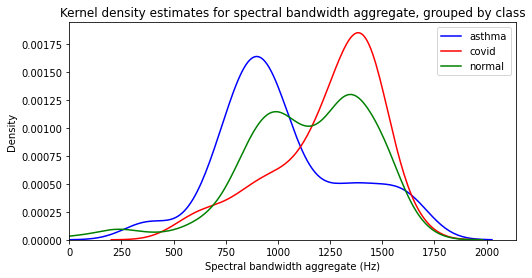

In [27]:
# Loading and plotting spectral bandwidth distributions.

with open('breath_dist_sb_asthma.pickle', 'rb') as f:
    sb_asthma_dist = pickle.load(f)
with open('breath_dist_sb_covid.pickle', 'rb') as f:
    sb_covid_dist = pickle.load(f)
with open('breath_dist_sb_normal.pickle', 'rb') as f:
    sb_normal_dist = pickle.load(f)

plt.figure(figsize=(8, 4))
plt.title(f'Kernel density estimates for spectral bandwidth aggregate, grouped by class')
sns.kdeplot(sb_asthma_dist, color='b', label='asthma')
sns.kdeplot(sb_covid_dist, color='r', label='covid')
sns.kdeplot(sb_normal_dist, color='g', label='normal')
plt.xlabel('Spectral bandwidth aggregate (Hz)')
plt.xlim([0, None])
plt.legend();

## Spectral rolloff

#### Results on representative samples from each class.

In [28]:
sr_asthma = spectral_rolloff(waveform_asthma, sampling_rate, samples_per_frame, hop_length, roll_percent=roll_percent)
sr_covid = spectral_rolloff(waveform_covid, sampling_rate, samples_per_frame, hop_length, roll_percent=roll_percent)
sr_normal = spectral_rolloff(waveform_normal, sampling_rate, samples_per_frame, hop_length, roll_percent=roll_percent)

Plotting spectral rolloff over waveform.

In [29]:
%%script echo "Output hidden for data privacy reasons."

# Converting frame index to time
times_asthma = librosa.frames_to_time(range(len(sr_asthma)), sr=sampling_rate, hop_length=hop_length)
times_covid = librosa.frames_to_time(range(len(sr_covid)), sr=sampling_rate, hop_length=hop_length)
times_normal = librosa.frames_to_time(range(len(sr_normal)), sr=sampling_rate, hop_length=hop_length)

fig, ax = plt.subplots(1, 3, sharex=True, figsize=(19, 5))
plt.suptitle('Spectral rolloff values for 3 representative audio samples, grouped by class; waveforms in lower row')

plt.subplot(2, 3, 1)
plt.plot(times_asthma, sr_asthma, color='r')
plt.ylabel('Spectral rolloff (Hz)')
plt.xlim([0, np.ceil(np.max(times_asthma))])
plt.title('asthma')

plt.subplot(2, 3, 4)
librosa.display.waveplot(waveform_asthma, sr=sampling_rate, x_axis='time', color='b', alpha=0.2)
plt.xlabel('Time (s)')
plt.ylabel('y')

plt.subplot(2, 3, 2)
plt.plot(times_covid, sr_covid, color='r')
plt.ylabel('Spectral rolloff (Hz)')
plt.xlim([0, np.ceil(np.max(times_covid))])
plt.title('covid')

plt.subplot(2, 3, 5)
librosa.display.waveplot(waveform_covid, sr=sampling_rate, x_axis='time', color='b', alpha=0.2)
plt.xlabel('Time (s)')
plt.ylabel('y')

plt.subplot(2, 3, 3)
plt.plot(times_normal, sr_normal, color='r')
plt.ylabel('Spectral rolloff (Hz)')
plt.xlim([0, np.ceil(np.max(times_normal))])
plt.title('normal')

plt.subplot(2, 3, 6)
librosa.display.waveplot(waveform_normal, sr=sampling_rate, x_axis='time', color='b', alpha=0.2)
plt.xlabel('Time (s)')
plt.ylabel('y');

Output hidden for data privacy reasons.


#### Aggregating spectral bandwidth values across frames, to get a single value for each audio sample, then plotting the distribution of the aggregated values.

In [30]:
%%script echo "Comment line with %%script echo to run this cell."

# Spectral rolloff distributions for asthma, covid and normal.
sr_asthma_dist = list()
sr_covid_dist = list()
sr_normal_dist = list()

# Aggregate spectral centroids distributions for asthma, covid and normal.
agg_func = 'median'    # Function to aggregate values over frames in audio sample, to get 1 value per audio sample.
for file in tqdm(os.listdir(dirpath_asthma)):
    file = os.path.join(dirpath_asthma, file)
    waveform, _ = librosa.load(file, sr=sampling_rate)
    sr_asthma_dist.append(spectral_rolloff_agg(waveform, sampling_rate, samples_per_frame, hop_length, roll_percent, agg_func))
for file in tqdm(os.listdir(dirpath_covid)):
    file = os.path.join(dirpath_covid, file)
    waveform, _ = librosa.load(file, sr=sampling_rate)
    sr_covid_dist.append(spectral_rolloff_agg(waveform, sampling_rate, samples_per_frame, hop_length, roll_percent, agg_func))
for file in tqdm(os.listdir(dirpath_normal)):
    file = os.path.join(dirpath_normal, file)
    waveform, _ = librosa.load(file, sr=sampling_rate)
    sr_normal_dist.append(spectral_rolloff_agg(waveform, sampling_rate, samples_per_frame, hop_length, roll_percent, agg_func))

Comment line with %%script echo to run this cell.


In [31]:
%%script echo "Comment line with %%script echo to run this cell."

# Saving spectral rolloff energy distributions.
with open('breath_dist_sr_asthma.pickle', 'wb') as f:
    pickle.dump(sr_asthma_dist, f)
with open('breath_dist_sr_covid.pickle', 'wb') as f:
    pickle.dump(sr_covid_dist, f)
with open('breath_dist_sr_normal.pickle', 'wb') as f:
    pickle.dump(sr_normal_dist, f)

Comment line with %%script echo to run this cell.


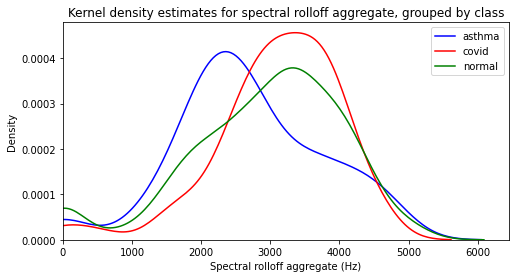

In [32]:
# Loading and plotting spectral rolloff distributions.

with open('breath_dist_sr_asthma.pickle', 'rb') as f:
    sr_asthma_dist = pickle.load(f)
with open('breath_dist_sr_covid.pickle', 'rb') as f:
    sr_covid_dist = pickle.load(f)
with open('breath_dist_sr_normal.pickle', 'rb') as f:
    sr_normal_dist = pickle.load(f)

plt.figure(figsize=(8, 4))
plt.title(f'Kernel density estimates for spectral rolloff aggregate, grouped by class')
sns.kdeplot(sr_asthma_dist, color='b', label='asthma')
sns.kdeplot(sr_covid_dist, color='r', label='covid')
sns.kdeplot(sr_normal_dist, color='g', label='normal')
plt.xlabel('Spectral rolloff aggregate (Hz)')
plt.xlim([0, None])
plt.legend();

## Mel frequency cepstrum coefficients (MFCCs)

#### Results on representative samples from each class.

In [33]:
# Number of MFCCs to consider, many applications use first 13 coefficients.
n_mfcc = 13

mfccs_asthma = mfcc(waveform_asthma, sampling_rate, samples_per_frame, hop_length, n_mfcc)
mfccs_covid = mfcc(waveform_covid, sampling_rate, samples_per_frame, hop_length, n_mfcc)
mfccs_normal = mfcc(waveform_normal, sampling_rate, samples_per_frame, hop_length, n_mfcc)

Sanity check for shape of MFCC arrays.

In [34]:
pad_length = samples_per_frame // 2
np.testing.assert_array_equal(mfccs_asthma.shape[1], (waveform_asthma.shape[0] + 2 * pad_length - samples_per_frame) // hop_length + 1)
np.testing.assert_array_equal(mfccs_covid.shape[1], (waveform_covid.shape[0] + 2 * pad_length - samples_per_frame) // hop_length + 1)
np.testing.assert_array_equal(mfccs_normal.shape[1], (waveform_normal.shape[0] + 2 * pad_length - samples_per_frame) // hop_length + 1)

Plotting MFCCs.

In [35]:
%%script echo "Output hidden for data privacy reasons."

fig, ax = plt.subplots(1, 3, figsize=(19, 4))
plt.suptitle('First 13 MFCCs, unscaled')

plt.subplot(1, 3, 1)
librosa.display.specshow(mfccs_asthma, x_axis='time')
plt.colorbar()
plt.title('asthma')
plt.xlabel('Time (s)')
plt.ylabel('MFCC')

plt.subplot(1, 3, 2)
librosa.display.specshow(mfccs_covid, x_axis='time')
plt.colorbar()
plt.title('covid')
plt.xlabel('Time (s)')
plt.ylabel('MFCC')

plt.subplot(1, 3, 3)
librosa.display.specshow(mfccs_normal, x_axis='time')
plt.colorbar()
plt.title('normal')
plt.xlabel('Time (s)')
plt.ylabel('MFCC');

Output hidden for data privacy reasons.


The first coefficient does not convey any information, except for a constant bias. It is usually discarded.  
Refer: https://musicinformationretrieval.com/mfcc.html

Performing scaling as it helps to visualize MFCCs better.

In [36]:
%%script echo "Output hidden for data privacy reasons."

mfccs_asthma_scaled = (mfccs_asthma - np.expand_dims(np.min(mfccs_asthma, axis=1), axis=1)) / (np.expand_dims(np.max(mfccs_asthma, axis=1), axis=1) - np.expand_dims(np.min(mfccs_asthma, axis=1), axis=1))
mfccs_covid_scaled = (mfccs_covid - np.expand_dims(np.min(mfccs_covid, axis=1), axis=1)) / (np.expand_dims(np.max(mfccs_covid, axis=1), axis=1) - np.expand_dims(np.min(mfccs_covid, axis=1), axis=1))
mfccs_normal_scaled = (mfccs_normal - np.expand_dims(np.min(mfccs_normal, axis=1), axis=1)) / (np.expand_dims(np.max(mfccs_normal, axis=1), axis=1) - np.expand_dims(np.min(mfccs_normal, axis=1), axis=1))
fig, ax = plt.subplots(1, 3, figsize=(19, 4))
plt.suptitle('First 13 MFCCs, min-max scaled')

plt.subplot(1, 3, 1)
librosa.display.specshow(mfccs_asthma_scaled, x_axis='time')
plt.colorbar()
plt.title('asthma')
plt.xlabel('Time (s)')
plt.ylabel('MFCC')

plt.subplot(1, 3, 2)
librosa.display.specshow(mfccs_covid_scaled, x_axis='time')
plt.colorbar()
plt.title('covid')
plt.xlabel('Time (s)')
plt.ylabel('MFCC')

plt.subplot(1, 3, 3)
librosa.display.specshow(mfccs_normal_scaled, x_axis='time')
plt.colorbar()
plt.title('normal')
plt.xlabel('Time (s)')
plt.ylabel('MFCC');

Output hidden for data privacy reasons.


#### Aggregating second MFCC values across frames, to get a single value for each audio sample, then plotting the distribution of the aggregated values.

Using second MFCC as first MFCC does not give much useful information.

In [37]:
%%script echo "Comment line with %%script echo to run this cell."

# MFCC2 distributions for asthma, covid and normal.
mfcc2_asthma_dist = list()
mfcc2_covid_dist = list()
mfcc2_normal_dist = list()

# Aggregate MFCC2 distributions for asthma, covid and normal.
agg_func = 'mean'    # Function to aggregate values over frames in audio sample, to get 1 value per audio sample.
for file in tqdm(os.listdir(dirpath_asthma)):
    file = os.path.join(dirpath_asthma, file)
    waveform, _ = librosa.load(file, sr=sampling_rate)
    mfcc2_asthma_dist.append(mfcc_agg(waveform, sampling_rate, samples_per_frame, hop_length, n_mfcc, agg_func)[1])
for file in tqdm(os.listdir(dirpath_covid)):
    file = os.path.join(dirpath_covid, file)
    waveform, _ = librosa.load(file, sr=sampling_rate)
    mfcc2_covid_dist.append(mfcc_agg(waveform, sampling_rate, samples_per_frame, hop_length, n_mfcc, agg_func)[1])
for file in tqdm(os.listdir(dirpath_normal)):
    file = os.path.join(dirpath_normal, file)
    waveform, _ = librosa.load(file, sr=sampling_rate)
    mfcc2_normal_dist.append(mfcc_agg(waveform, sampling_rate, samples_per_frame, hop_length, n_mfcc, agg_func)[1])

Comment line with %%script echo to run this cell.


In [38]:
%%script echo "Comment line with %%script echo to run this cell."

# Saving MFCC2 distributions.
with open('breath_dist_mfcc2_asthma.pickle', 'wb') as f:
    pickle.dump(mfcc2_asthma_dist, f)
with open('breath_dist_mfcc2_covid.pickle', 'wb') as f:
    pickle.dump(mfcc2_covid_dist, f)
with open('breath_dist_mfcc2_normal.pickle', 'wb') as f:
    pickle.dump(mfcc2_normal_dist, f)

Comment line with %%script echo to run this cell.


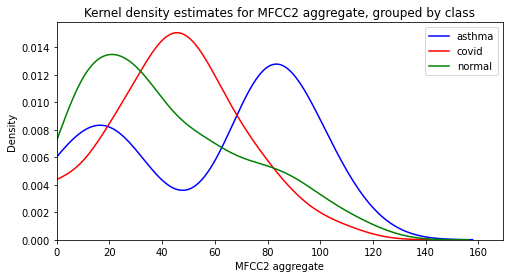

In [39]:
# Loading and plotting MFCC2 distributions.

with open('breath_dist_mfcc2_asthma.pickle', 'rb') as f:
    mfcc2_asthma_dist = pickle.load(f)
with open('breath_dist_mfcc2_covid.pickle', 'rb') as f:
    mfcc2_covid_dist = pickle.load(f)
with open('breath_dist_mfcc2_normal.pickle', 'rb') as f:
    mfcc2_normal_dist = pickle.load(f)

plt.figure(figsize=(8, 4))
plt.title(f'Kernel density estimates for MFCC2 aggregate, grouped by class')
sns.kdeplot(mfcc2_asthma_dist, color='b', label='asthma')
sns.kdeplot(mfcc2_covid_dist, color='r', label='covid')
sns.kdeplot(mfcc2_normal_dist, color='g', label='normal')
plt.xlabel('MFCC2 aggregate')
plt.xlim([0, None])
plt.legend();

## First derivative of MFCCs

#### Results on representative samples from each class.

In [40]:
# Number of MFCCs to consider, many applications use first 13 coefficients.
n_mfcc = 13

dmfccs_asthma = dmfcc(waveform_asthma, sampling_rate, samples_per_frame, hop_length, n_mfcc)
dmfccs_covid = dmfcc(waveform_covid, sampling_rate, samples_per_frame, hop_length, n_mfcc)
dmfccs_normal = dmfcc(waveform_normal, sampling_rate, samples_per_frame, hop_length, n_mfcc)

Sanity check for shape of dMFCC arrays.

In [41]:
pad_length = samples_per_frame // 2
np.testing.assert_array_equal(dmfccs_asthma.shape[1], (waveform_asthma.shape[0] + 2 * pad_length - samples_per_frame) // hop_length + 1)
np.testing.assert_array_equal(dmfccs_covid.shape[1], (waveform_covid.shape[0] + 2 * pad_length - samples_per_frame) // hop_length + 1)
np.testing.assert_array_equal(dmfccs_normal.shape[1], (waveform_normal.shape[0] + 2 * pad_length - samples_per_frame) // hop_length + 1)

Plotting dMFCCs.

In [42]:
%%script echo "Output hidden for data privacy reasons."

fig, ax = plt.subplots(1, 3, figsize=(19, 4))
plt.suptitle('First 13 MFCCs, unscaled')

plt.subplot(1, 3, 1)
librosa.display.specshow(dmfccs_asthma, x_axis='time')
plt.colorbar()
plt.title('asthma')
plt.xlabel('Time (s)')
plt.ylabel('MFCC')

plt.subplot(1, 3, 2)
librosa.display.specshow(dmfccs_covid, x_axis='time')
plt.colorbar()
plt.title('covid')
plt.xlabel('Time (s)')
plt.ylabel('MFCC')

plt.subplot(1, 3, 3)
librosa.display.specshow(dmfccs_normal, x_axis='time')
plt.colorbar()
plt.title('normal')
plt.xlabel('Time (s)')
plt.ylabel('MFCC');

Output hidden for data privacy reasons.


Does not look like there is much information in the DMFCC plots.

Performing scaling on DMFCC to see if there is any information can be extracted.

In [43]:
%%script echo "Output hidden for data privacy reasons."

dmfccs_asthma_scaled = (dmfccs_asthma - np.expand_dims(np.min(dmfccs_asthma, axis=1), axis=1)) / (np.expand_dims(np.max(dmfccs_asthma, axis=1), axis=1) - np.expand_dims(np.min(dmfccs_asthma, axis=1), axis=1))
dmfccs_covid_scaled = (dmfccs_covid - np.expand_dims(np.min(dmfccs_covid, axis=1), axis=1)) / (np.expand_dims(np.max(dmfccs_covid, axis=1), axis=1) - np.expand_dims(np.min(dmfccs_covid, axis=1), axis=1))
dmfccs_normal_scaled = (dmfccs_normal - np.expand_dims(np.min(dmfccs_normal, axis=1), axis=1)) / (np.expand_dims(np.max(dmfccs_normal, axis=1), axis=1) - np.expand_dims(np.min(dmfccs_normal, axis=1), axis=1))
fig, ax = plt.subplots(1, 3, figsize=(19, 4))
plt.suptitle('First 13 DMFCCs, min-max scaled')

plt.subplot(1, 3, 1)
librosa.display.specshow(dmfccs_asthma_scaled, x_axis='time')
plt.colorbar()
plt.title('asthma')
plt.xlabel('Time (s)')
plt.ylabel('DMFCC')

plt.subplot(1, 3, 2)
librosa.display.specshow(dmfccs_covid_scaled, x_axis='time')
plt.colorbar()
plt.title('covid')
plt.xlabel('Time (s)')
plt.ylabel('DMFCC')

plt.subplot(1, 3, 3)
librosa.display.specshow(dmfccs_normal_scaled, x_axis='time')
plt.colorbar()
plt.title('normal')
plt.xlabel('Time (s)')
plt.ylabel('DMFCC');

Output hidden for data privacy reasons.


Also looks random.

Does not seem useful to extract d2MFCCs.